# Speed Dating 

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

In [119]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm
import sklearn.feature_selection as fs
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [120]:
data = pd.read_csv('Speed Dating Data.csv',encoding="ISO-8859-1").rename(columns=lambda x: x.strip())

## Descriptive Analysis

In [121]:
descrp=data.copy()

In [122]:
#dropping duplicates for each participant 
descrp=descrp.drop_duplicates(subset='iid', keep='first', inplace=False)

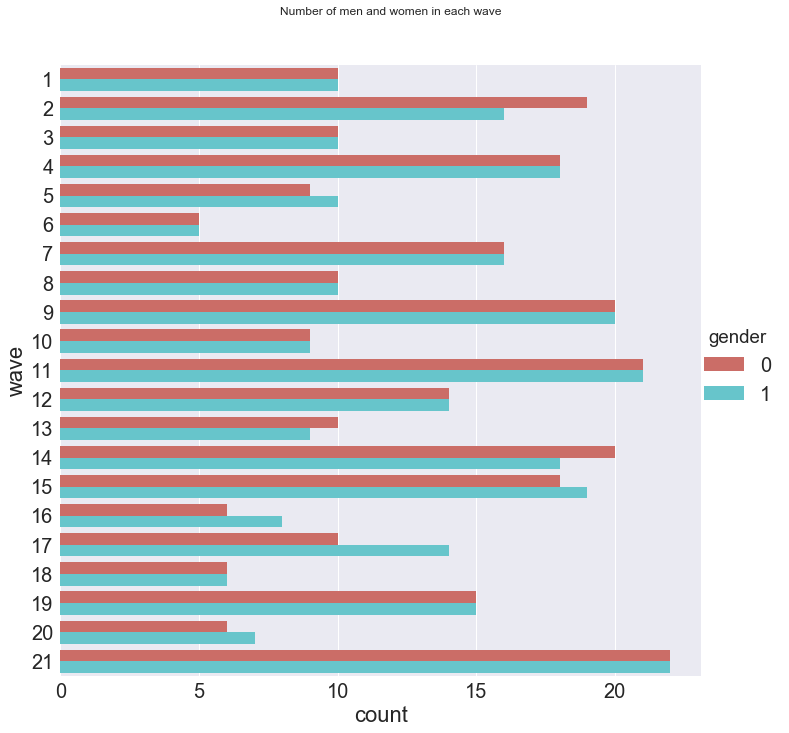

In [123]:
plot1= sns.factorplot(y="wave", hue='gender',data=descrp, size=10, kind="count", palette='hls',orient='h')
plt.subplots_adjust(top=0.9)
plot1.fig.suptitle('Number of men and women in each wave');

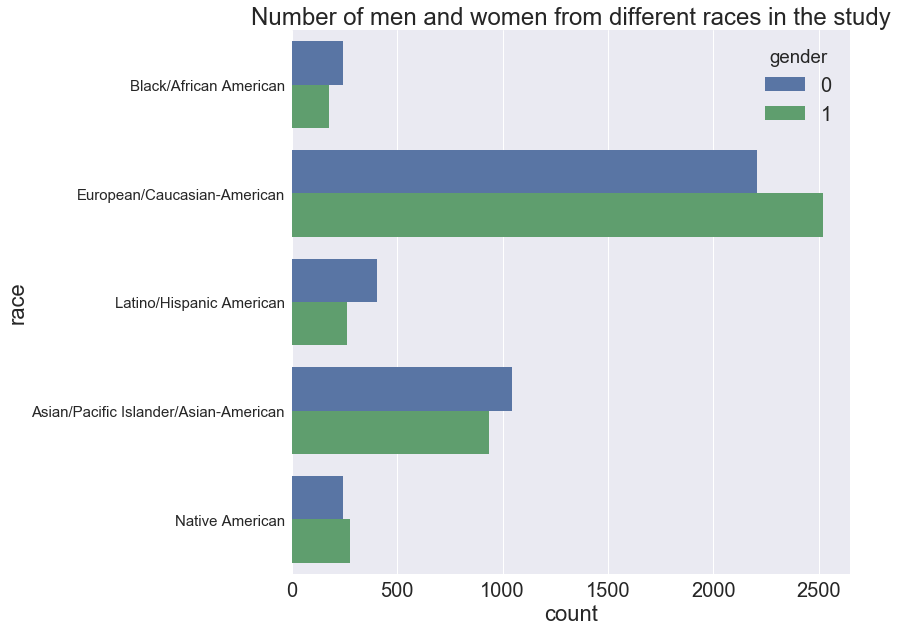

In [184]:
#distribution o race among the sexes

race = ['Black/African American','European/Caucasian-American','Latino/Hispanic American',
        'Asian/Pacific Islander/Asian-American','Native American','Other']
plot2 = plt.figure(figsize=(10,10))
plot2= sns.countplot(y="race",data=data, hue='gender')
plot2.set(yticklabels=race)

plot2.set_title('Number of men and women from different races in the study');
g = plt.yticks(rotation=0,fontsize=15);

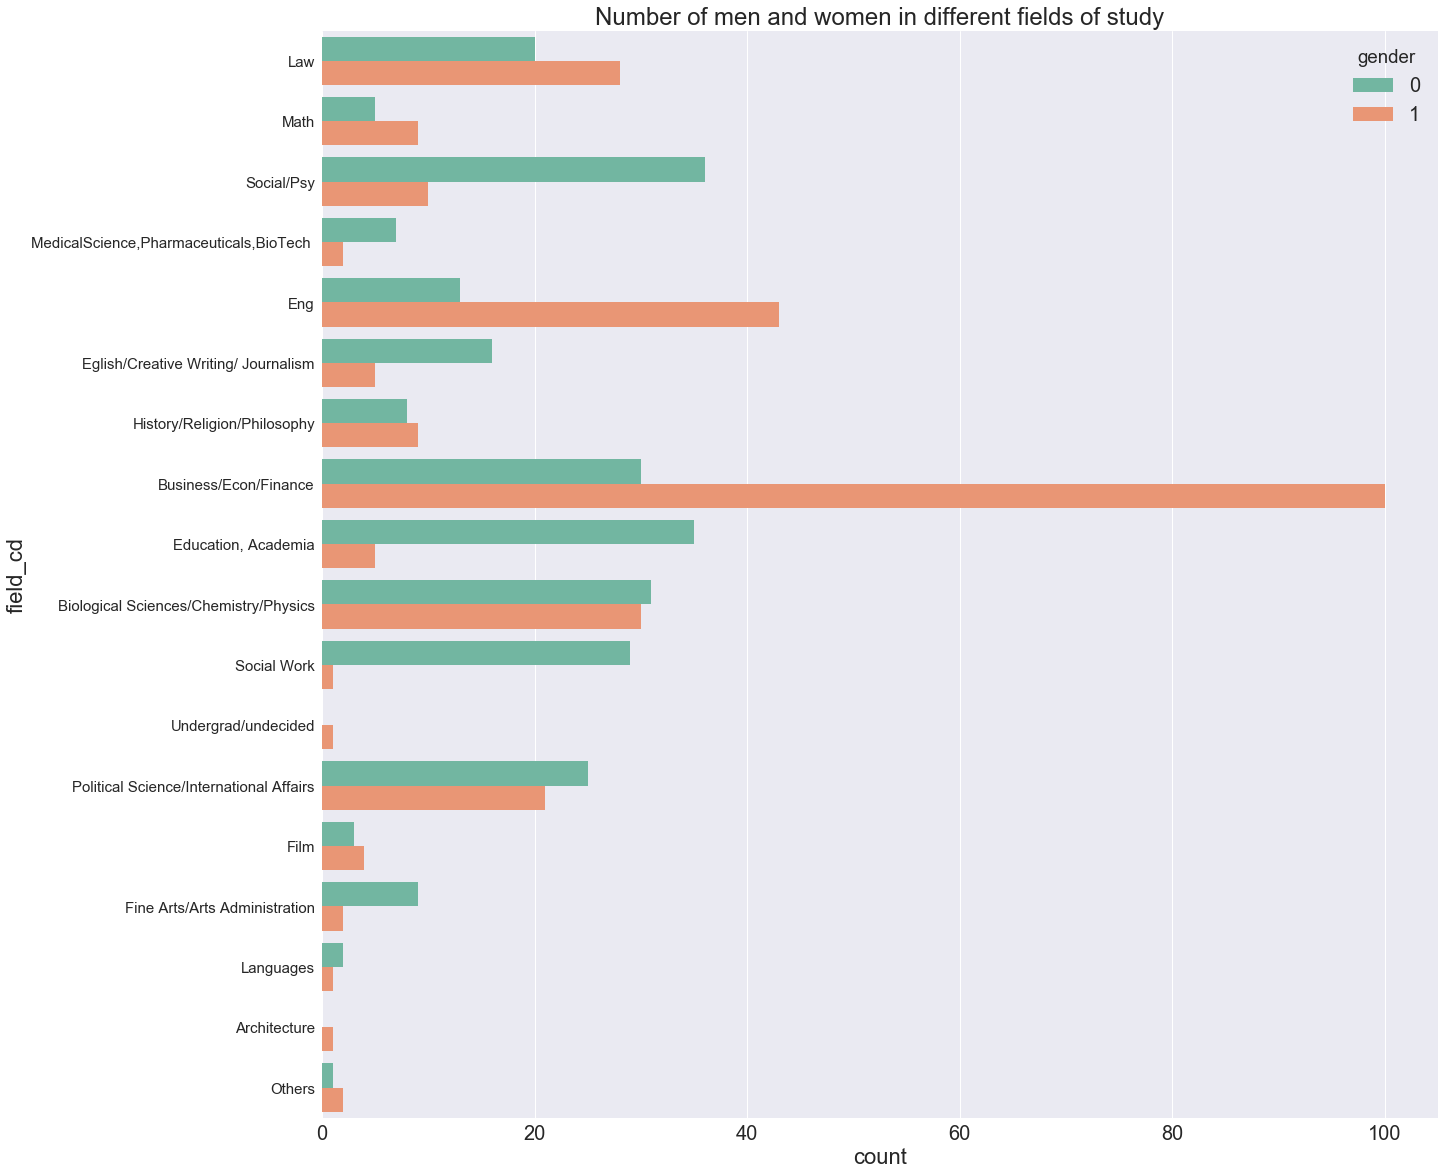

In [125]:
field_cd = ['Law','Math','Social/Psy','MedicalScience,Pharmaceuticals,BioTech ',
                   'Eng','Eglish/Creative Writing/ Journalism','History/Religion/Philosophy',
                  'Business/Econ/Finance','Education, Academia','Biological Sciences/Chemistry/Physics',
                  'Social Work','Undergrad/undecided','Political Science/International Affairs',
                  'Film','Fine Arts/Arts Administration','Languages','Architecture','Others']
plot3 = plt.figure(figsize=(20,20))
plot3 = sns.countplot(y="field_cd",data=descrp, hue='gender', palette="Set2")
plot3.set(yticklabels=field_cd)
plot3.set_title('Number of men and women in different fields of study')
plot3 = plt.yticks(rotation=0,fontsize=15);

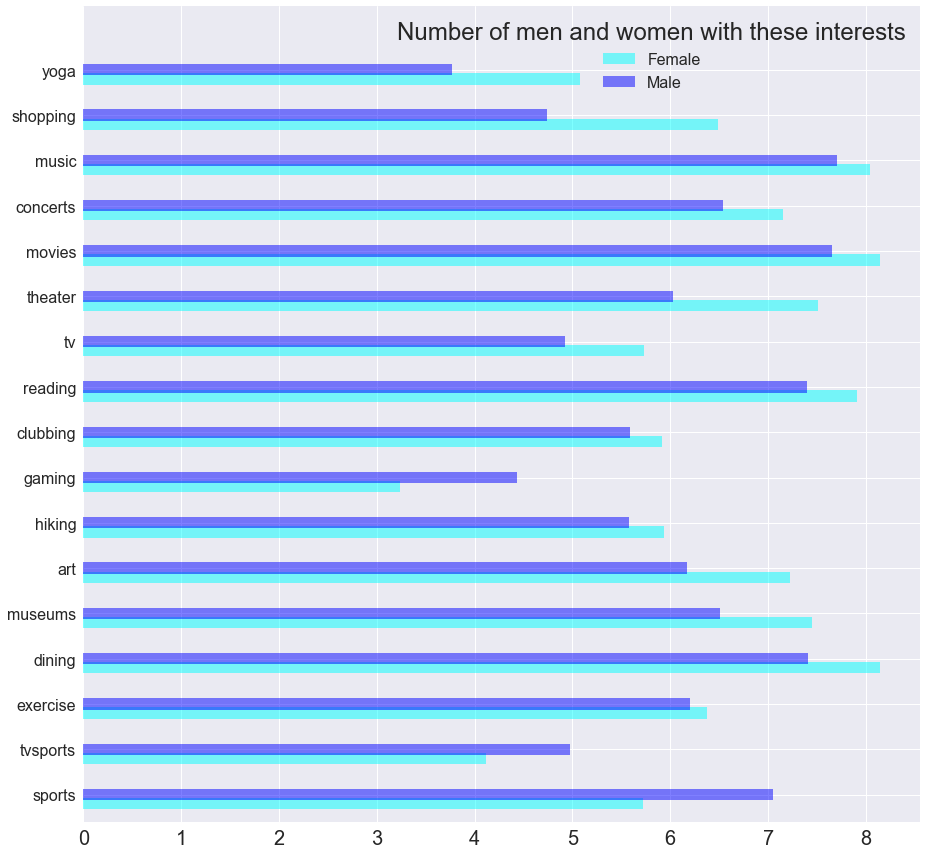

In [126]:
#interests in general men and women like to do 

activities_interested=['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading',
                       'tv','theater','movies','concerts','music','shopping','yoga']
temp = descrp.groupby(['gender']).mean()[activities_interested].values

plot4= plt.figure(figsize=(15,15))
plot4= plt.barh(np.arange(0,2*temp.shape[1],2)-0.2,temp[0,:], height=0.5,color=[0,1,1],alpha=0.5,label='Female')
plot4 = plt.barh(np.arange(0,2*temp.shape[1],2)+0.2,temp[1,:], height=0.5,color=[0,0,1],alpha=0.5,label='Male')
plot4 = plt.yticks(np.arange(0,2*temp.shape[1],2)+0.2,activities_interested,fontsize=16)
plot4 = plt.ylim(-1,2*temp.shape[1]+1)
plot4 = plt.legend(loc=0,fontsize=16)
plot4.set_title('Number of men and women with these interests');

## <u>Cleanning data </u>

In [127]:
sd_org=data.copy()

According to the paper, "Seven waves have been omitted: one because we imposed a maximum number of acceptances, two because we were unable to attract sufficient participants, and four because they involved an experimental intervention where participants were asked to bring their favorite book." We identified those 7 waves based data key provided and exluded them.

In [128]:
# select waves that had been used in the paper 
wave=[6,12,16,18,19,20,21]
sd = sd_org[~sd_org['wave'].isin(wave)]
sd.wave.unique()

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 17], dtype=int64)

In [129]:
# convert income to numeric values
sd['income'] = sd['income'].str.replace(',', '')
sd['income']= pd.to_numeric(sd['income'])

C:\Users\falih\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\falih\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [130]:
# Drop those colunms for 'half way through' phase 
sd= sd.drop(['attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s',
             'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s'],axis=1)

In [131]:
# Drop those colunms for 'follow-up 2' phase, becuase these were filled out after 3-4 
# weeks after the event. A lot of them were NaN values and we think that participants 
# might not remember very clearly by that time. 

sd= sd.drop(['attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3',
             'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3',
             'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3',
             'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3',
             'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3', 
             'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3',],axis=1)

In [132]:
# Drop attr7_2, because it doesn't pair up with the question asked in the correspoding sign up phase.
sd= sd.drop('attr7_2',axis=1)

In [133]:
# Drop those columns that won't be used in this analysis 
sd= sd.drop(['id', 'idg', 'wave','round','condtn', 'position', 'positin1','partner','pid','int_corr',
             'age_o','race_o','from','zipcode','career','career_c','satis_2','length',
             'pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha','field',
             'undergra','mn_sat','tuition','exphappy','expnum','numdat_2','samerace',
             'match_es','you_call','them_cal','date_3','numdat_3','num_in_3'],axis=1)

In [134]:
# group those attributes suing 1-10 scales
ten = ['attr3_1', 'sinc3_1',
       'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1',
       'fun5_1', 'amb5_1','attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2',
       'attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2']

# group those attributes using 100 point system
hrd = ['attr1_1', 'sinc1_1',
       'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1',
       'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1',
       'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1','sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2',
       'shar7_2', 'attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2',
       'shar1_2', 'attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2',
       'shar4_2', 'attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2',
       'shar2_2']

In [135]:
# Normalize two different scales 

# Normalize 10 point scale
sd[ten]=sd[ten].apply(lambda x: ((x-1)/9))

# Normalize 100 point scale
sd[hrd]=sd[hrd].apply(lambda x: x/100)

In [136]:
# final columns to keep 
sd.columns

Index(['iid', 'gender', 'order', 'match', 'dec_o', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o',
       ...
       'attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2', 'attr5_2',
       'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2'],
      dtype='object', length=111)

### Description of the columns <br><br>


| Column | Description |
|--------|-------------|
|`dec_o`|1 = yes, 0 = no|
|`sports`|scale of 1-10|
|`tvsports`| scale of 1-10|
|`exercise`| scale of 1-10|
|`dining`| scale of 1-10|
|`museums`| scale of 1-10|
|`art`| scale of 1-10|
|`hiking`| scale of 1-10|
|`gaming`|scale of 1-10|
|`clubbing`|scale of 1-10|
|`reading`|scale of 1-10|
|`tv`|scale of 1-10|
|`theater`|scale of 1-10|
|`movies`|scale of 1-10|
|`music`|scale of 1-10|
|`shopping`|scale of 1-10|
|`yoga`|scale of 1-10|


### ### What do you look for in the opposite sex SIGNUP vs FOLLOWUP

Six attributes were asked to be ranked by each participant-  Attractive, Sincere,Intelligent,Fun,Ambitious and Shared Interests.
We wanted to know which attributes were given the most points by men and women at signup and followup to see if there are any differences in the gender or the two different times of the experiment.

In [229]:
#picking columns for the attributes
signup=sd[['iid','gender','attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1']]
followup=sd[['iid','gender','attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2']]



In [230]:
#dropping any null values
signup=signup.dropna(axis=0,how='any')

followup=followup.dropna(axis=0,how='any')


In [231]:
#each participant filled out only one form at signup and followup , but met multiple people,
#hence the form values were duplicated in the dataset

#removing duplicate valyes
signup=signup.drop_duplicates(subset=None, keep='first', inplace=False)

followup=followup.drop_duplicates(subset=None, keep='first', inplace=False)


In [226]:
#melting the dataset to transfrom the 6 columns into 1
signupmelt=pd.melt(signup,id_vars=['gender'], value_vars=['attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1'], var_name ='Attributes', value_name = 'AttributeValue')


followupmelt=pd.melt(followup,id_vars=['gender'], value_vars=['attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2'], var_name ='Attributes', value_name = 'AttributeValue')


,gender,Attributes,AttributeValue
0,0,attr1_2,0.1944
1,0,attr1_2,0.1892
2,0,attr1_2,0.2414
3,0,attr1_2,0.1579
4,0,attr1_2,0.1026


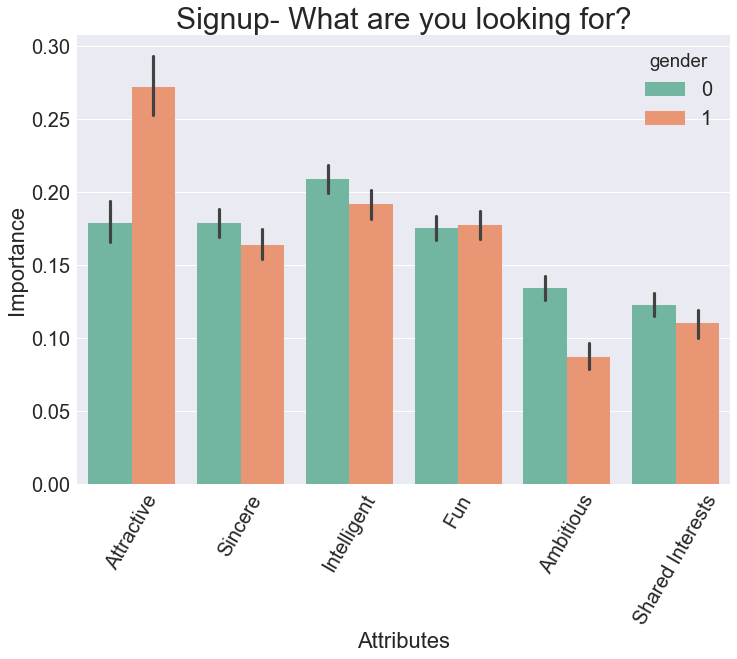

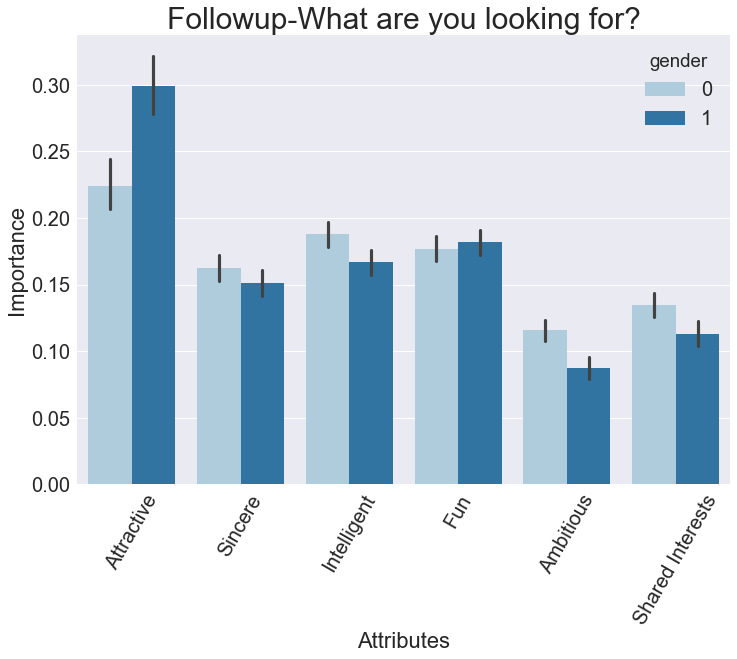

In [228]:
#plotting the highest rated attribute for signup and follow up

sns.set(font_scale = 2) #increasing the plot size
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)


plot5 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=signupmelt,palette="Set2")
plot5.set(xlabel='Attributes', ylabel='Importance')
plot5.set_title("Signup- What are you looking for?",fontsize=30)
plot5.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests'])#renaming the x axis ticks
plot5.set_xticklabels(plot1.get_xticklabels(),rotation=60)
plt.show();



#plotting the followup data
a4_dims = (11.7, 8.27) 
fig, ax = pyplot.subplots(figsize=a4_dims) 

plot6 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=followupmelt, palette="Paired")
plot6.set(xlabel='Attributes', ylabel='Importance')
plot6.set_title("Followup-What are you looking for?", fontsize=30)
plot6.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests']) 
plot6.set_xticklabels(plot2.get_xticklabels(),rotation=60)
plt.show();

## Feature Selection for Men and Women at Signup vs Followup

In [197]:
male=sd[sd.gender==1]

In [198]:
malesignup=male[['match','attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1']]
malefollowup=male[['match','attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2']]

In [199]:
malesignup=malesignup.dropna(axis=0,how='any')
malefollowup=malefollowup.dropna(axis=0,how='any')

In [200]:
X1, y1 = malesignup.drop(['match'], axis=1), malesignup['match']
X2, y2 = malefollowup.drop(['match'], axis=1), malefollowup['match']

In [203]:
#signup
kb = fs.SelectKBest(k=3)
kb.fit(X1, y1)  
names = X1.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])

#Sorting the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)



SelectKBest(k=3, score_func=<function f_classif at 0x000001CA9C2F4400>)

  Feat_names  F_Scores
1    sinc1_1  7.777656
2    shar1_1  4.201647
0    attr1_1  3.609222


In [204]:
#followup
kb = fs.SelectKBest(k=3)
kb.fit(X2, y2)
names = X2.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])

#Sorting the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=3, score_func=<function f_classif at 0x000001CA9C2F4400>)

  Feat_names  F_Scores
1     fun1_2  14.42849
2     amb1_2   1.58611
0    sinc1_2   1.27101


#### Female

In [205]:
female=sd[sd.gender==0]

In [206]:
femalesignup=female[['match','attr1_1','sinc1_1','intel1_1','fun1_1',\
        'amb1_1','shar1_1']]

femalefollowup=female[['match','attr1_2','sinc1_2','intel1_2','fun1_2',\
        'amb1_2','shar1_2']]

In [207]:
femalesignup=femalesignup.dropna(axis=0,how='any')
femalefollowup=femalefollowup.dropna(axis=0,how='any')

In [208]:
X3,y3= femalesignup.drop(['match'], axis=1), femalesignup['match']
X4, y4 = femalefollowup.drop(['match'], axis=1), femalefollowup['match']

In [209]:
kb = fs.SelectKBest(k=3)
kb.fit(X3, y3)  
names = X3.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=3, score_func=<function f_classif at 0x000001CA9C2F4400>)

  Feat_names  F_Scores
2    shar1_1  8.660441
1     fun1_1  6.705976
0   intel1_1  1.303869


In [210]:
kb = fs.SelectKBest(k=3)
kb.fit(X4, y4) 
names = X4.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=3, score_func=<function f_classif at 0x000001CA9C2F4400>)

  Feat_names   F_Scores
1     fun1_2  12.409752
2     amb1_2   5.905993
0    sinc1_2   0.461899


### What do you think the opposite sex looks for 

In [256]:
#picking columns for the attributes
signup2=sd[['iid','gender','attr2_1','sinc2_1','intel2_1','fun2_1',\
        'amb2_1','shar2_1']]
followup2=sd[['iid','gender','attr2_2','sinc2_2','intel2_2','fun2_2',\
        'amb2_2','shar2_2']]

In [257]:
#dropping any null values
signup2=signup2.dropna(axis=0,how='any')

followup2=followup2.dropna(axis=0,how='any')


In [258]:
#each participant filled out only one form at signup and followup , but met multiple people,
#hence the form values were duplicated in the dataset

#removing duplicate valyes
signup2=signup2.drop_duplicates(subset=None, keep='first', inplace=False)

followup2=followup2.drop_duplicates(subset=None, keep='first', inplace=False)



In [263]:
#melting the dataset to transfrom the 6 columns into 1
signupmelt2=pd.melt(signup2,id_vars=['gender'], value_vars=['attr2_1','sinc2_1','intel2_1','fun2_1',\
        'amb2_1','shar2_1'], var_name ='Attributes', value_name = 'AttributeValue')

signupmelt2.head()
followupmelt2=pd.melt(followup2,id_vars=['gender'], value_vars=['attr2_2','sinc2_2','intel2_2','fun2_2',\
        'amb2_2','shar2_2'], var_name ='Attributes', value_name = 'AttributeValue')
followupmelt2.head()

,gender,Attributes,AttributeValue
0,0,attr2_1,0.35
1,0,attr2_1,0.65
2,0,attr2_1,0.50
3,0,attr2_1,0.30
4,0,attr2_1,0.50


,gender,Attributes,AttributeValue
0,0,attr2_2,0.1915
1,0,attr2_2,0.1667
2,0,attr2_2,0.2093
3,0,attr2_2,0.2041
4,0,attr2_2,0.2326


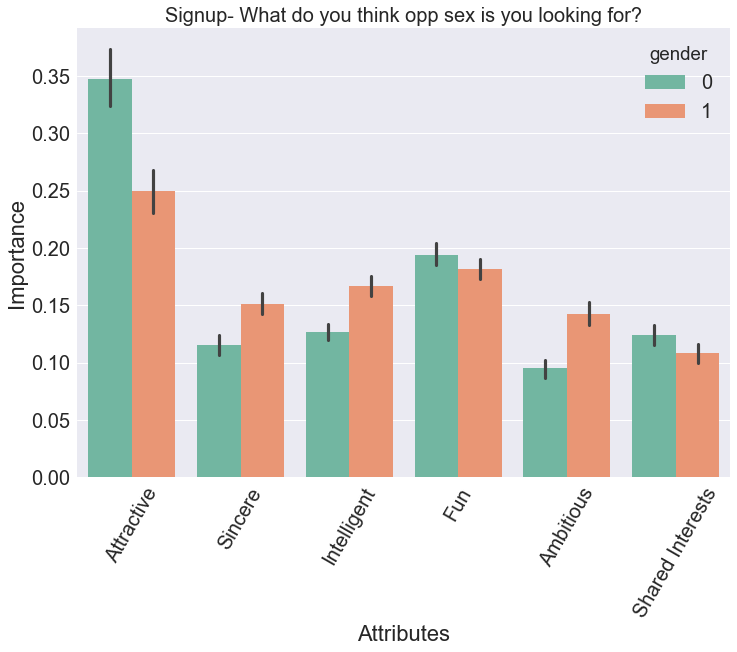

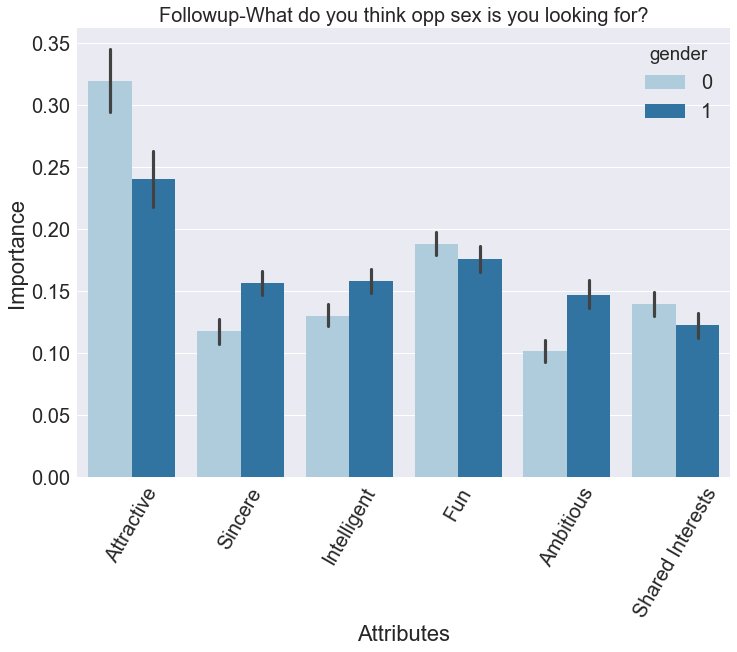

In [264]:
#plotting the highest rated attribute for signup and follow up

sns.set(font_scale = 2) #increasing the plot size
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)


plot7 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=signupmelt2,palette="Set2")
plot7.set(xlabel='Attributes', ylabel='Importance')
plot7.set_title("Signup- What do you think opp sex is you looking for?",fontsize=20)
plot7.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests'])#renaming the x axis ticks
plot7.set_xticklabels(plot1.get_xticklabels(),rotation=60)
plt.show();



#plotting the followup data
a4_dims = (11.7, 8.27) 
fig, ax = pyplot.subplots(figsize=a4_dims) 

plot8 = sns.barplot(x="Attributes", y="AttributeValue", hue="gender", data=followupmelt2, palette="Paired")
plot8.set(xlabel='Attributes', ylabel='Importance')
plot8.set_title("Followup-What do you think opp sex is you looking for?",fontsize=20)
plot8.set_xticklabels(['Attractive','Sincere','Intelligent','Fun','Ambitious','Shared Interests']) 
plot8.set_xticklabels(plot2.get_xticklabels(),rotation=60)
plt.show();

### <u>Clustering</u>


We wanted to cluster the dataset using participants' interests and character attributes from the sign up phase. Our initial approach was to check the correlations among these variables and dropped one variable in pairs with high correlations.

In [137]:
# features we want to include in our analysis for sign up phase
features =['gender','match','order','age','field_cd','race','imprace','imprelig','date','go_out',
           'sports','tvsports','exercise','dining','museums','art','hiking','gaming',
           'clubbing','reading','tv','theater','movies','music','shopping','yoga',
           'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
           'attr2_1', 'sinc2_1','intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1',
           'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']

In [138]:
# correlations between features
sd[features].corr().head()

,gender,match,order,age,field_cd,race,imprace,imprelig,date,go_out,...,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
gender,1.000000,-0.000724,0.011169,0.050314,-0.044815,-0.015109,-0.120605,-0.221355,-0.115661,0.029871,...,0.259003,0.331696,-0.094029,0.330487,-0.140487,-0.143832,-0.124351,-0.141560,0.074327,-0.044746
match,-0.000724,1.000000,-0.049440,-0.041184,-0.025949,-0.006540,-0.065969,-0.039233,-0.062664,-0.074592,...,-0.014450,0.018337,-0.015835,-0.011426,-0.027185,0.055283,0.010663,0.075463,0.019851,0.020332
order,0.011169,-0.049440,1.000000,0.047034,0.044093,-0.043188,0.023882,0.047862,0.016869,0.022947,...,0.025100,0.018197,-0.043251,0.029522,0.018438,-0.001733,0.015296,-0.010031,0.042208,0.000035
age,0.050314,-0.041184,0.047034,1.000000,0.158803,-0.081850,-0.123832,-0.070267,0.038015,0.143562,...,0.008460,-0.058504,-0.036226,-0.034174,-0.045239,0.059097,-0.036548,-0.083703,-0.032883,-0.066498
field_cd,-0.044815,-0.025949,0.044093,0.158803,1.000000,0.027053,0.021084,-0.041499,-0.053468,-0.027092,...,0.093752,0.124108,-0.079170,0.107205,0.105485,0.076094,0.033112,0.050488,-0.054842,0.070902


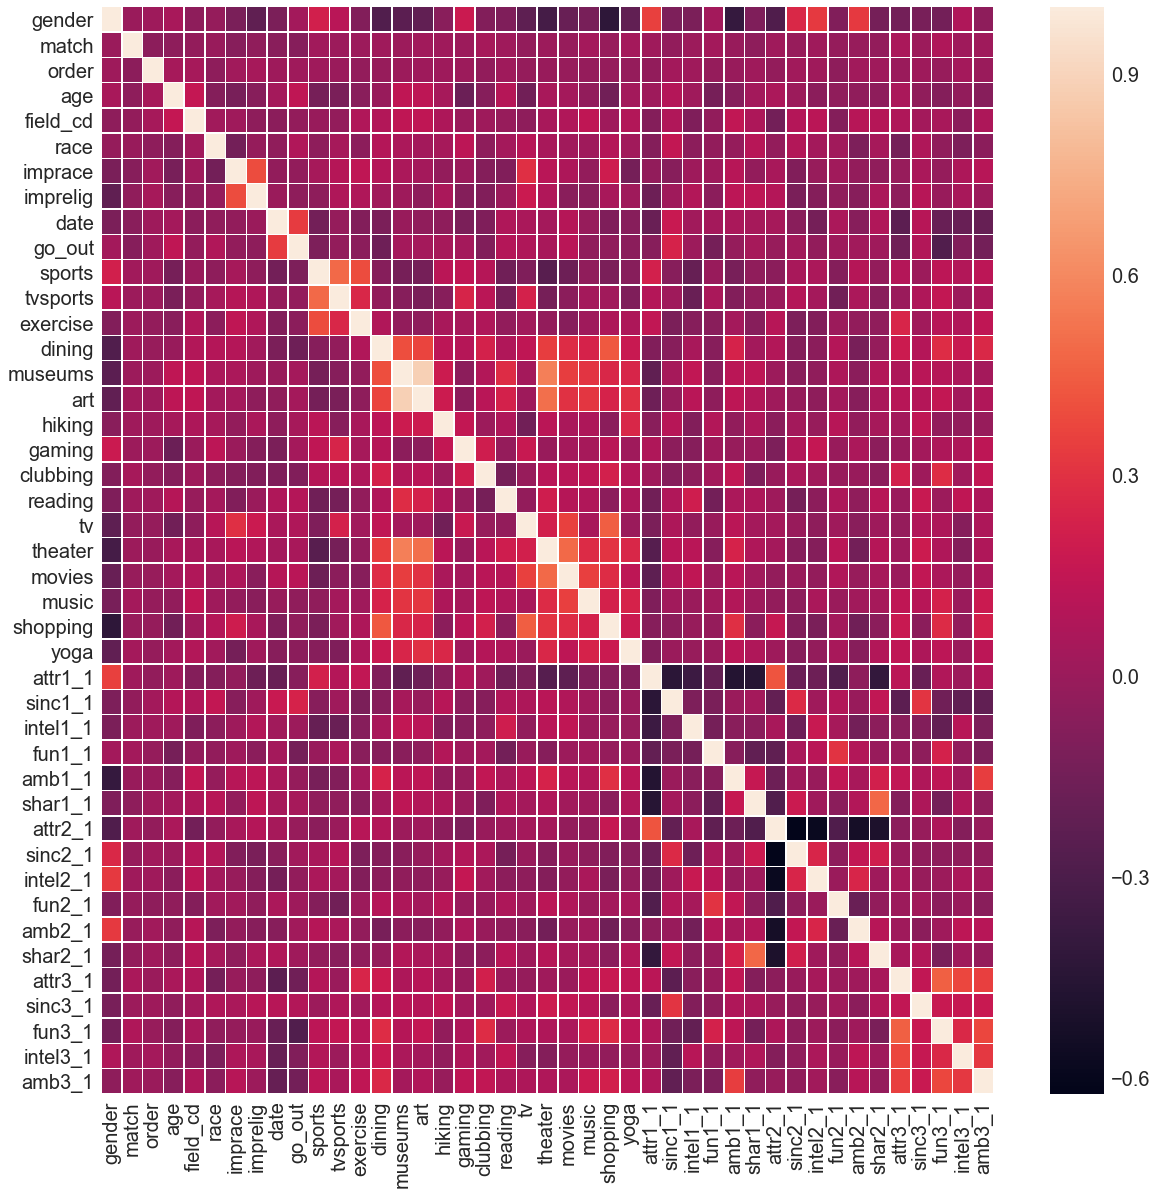

In [139]:
# heatmap of the correlations
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(sd[features].corr(),linewidths=.5, ax=ax)

In [140]:
# drop one feature in the pairs that have high correlations
keep =['gender','match','order','age','field_cd','race','imprace','income','date',
       'exercise','museums','hiking','gaming','clubbing','reading','tv','music','yoga',
       'sinc1_1', 'intel1_1','fun1_1', 'amb1_1', 'shar1_1','intel2_1', 'fun2_1',
       'sinc3_1','fun3_1', 'intel3_1']

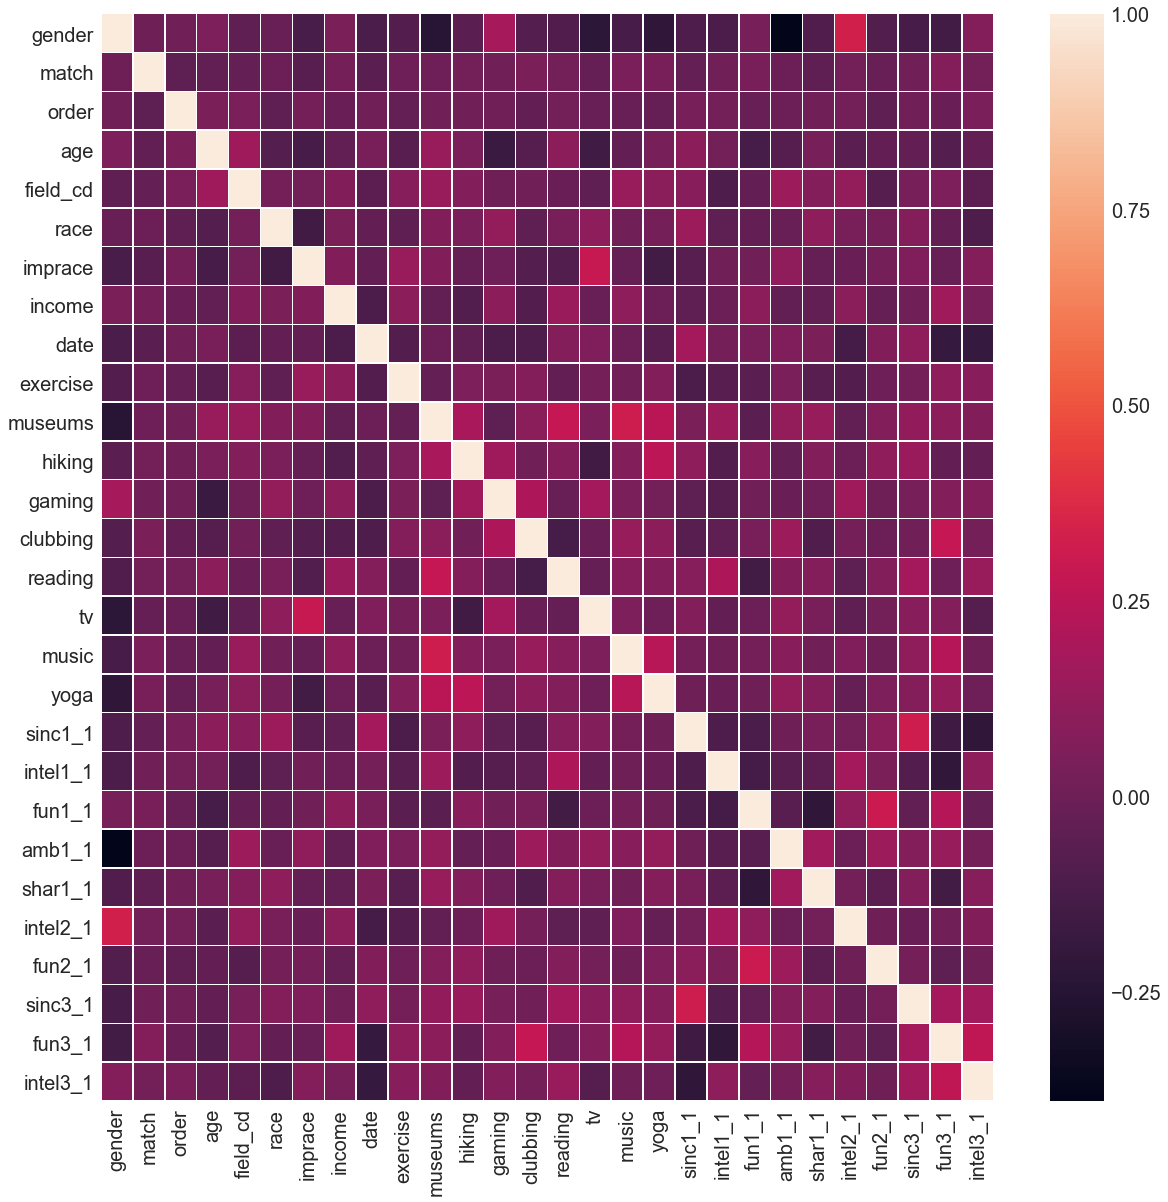

In [141]:
# run the heat map again to make sure the correlations are within a reasonable range 
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(sd[keep].corr(),linewidths=.5, ax=ax)

We decided to drop all NaN values instead of imputing them in some way, because these are all personal preference rankings, it doesn't make sense to impose the mean or median of other people's ranking to a specific participant who was either unwilling or unable to give the ranking at the time. 

In [142]:
# drop all NaN values 
temp1 = sd[keep].dropna()

We compared 3 different clustering models using different numbers of clusters and trying to pick the best one. 

In [143]:
# we got this code from Michele Samorani's Phython class note. See reference at the bottom.
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

bestSil = -1
for k in range(2,6):
    clus = [KMeans(n_clusters=k,n_jobs=-1), Birch(n_clusters=k), 
            AgglomerativeClustering(n_clusters=k)]
    for cl in clus:
        res = cl.fit(temp1)
        sil = metrics.silhouette_score(temp1, res.labels_)
        print (str(cl)[:10] + ' with k =' +str(k) + ": " + str(round(sil,4)))
        if (sil > bestSil):
            bestSil = sil
            bestCl = cl

KMeans(alg with k =2: 0.5543
Birch(bran with k =2: 0.5823
Agglomerat with k =2: 0.5823
KMeans(alg with k =3: 0.5995
Birch(bran with k =3: 0.5767
Agglomerat with k =3: 0.5767
KMeans(alg with k =4: 0.5756
Birch(bran with k =4: 0.5595
Agglomerat with k =4: 0.5595
KMeans(alg with k =5: 0.5845
Birch(bran with k =5: 0.575
Agglomerat with k =5: 0.575


The results are very close. We were expecting something over 0.7 to give us better clusters. The number shows that KMeans with cluster of 3 is the best option here. 

In [144]:
kmeans = KMeans(n_clusters=3)

In [145]:
cluster = kmeans.fit_predict(temp1)

In [146]:
temp1['cluster']=cluster

In [147]:
temp1.groupby('cluster').mean()

,gender,match,order,age,field_cd,race,imprace,income,date,exercise,...,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,intel2_1,fun2_1,sinc3_1,fun3_1,intel3_1
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.456477,0.176833,8.851953,25.638794,7.661412,2.565456,3.655243,49346.006854,4.878684,6.668266,...,0.175251,0.205694,0.180265,0.115352,0.116684,0.144609,0.178650,0.805575,0.790953,0.834057
1,0.378549,0.164038,9.093849,26.723186,7.128549,2.376972,3.875394,29461.559937,5.313880,6.267350,...,0.174654,0.203790,0.175217,0.116418,0.122118,0.133706,0.191776,0.797231,0.694795,0.831668
2,0.418410,0.202929,9.248954,25.581590,7.228033,2.594142,4.600418,75115.211297,4.979079,6.861925,...,0.157323,0.205701,0.197954,0.111615,0.114808,0.143273,0.187007,0.827290,0.776848,0.860065


The result was not that good. It did not give a fairly clear cluster. Also since our dateset has already been labeled, we decided to move to classification instead of clustering. 

### <u>Classification</u>

#### Interests

We wanted to see how your interests influence your partner's decision. We did this on two race groups to find out whether the interests that got you partner to say yes changed among different races. 

In [148]:
# select interests
interest = ['dec_o','sports','tvsports','exercise','dining','museums','art','hiking',
            'gaming','clubbing','reading','tv','theater','movies','music','shopping',
            'yoga']

Classification over interest on major race group: European/Caucasian-American

In [149]:
# include waves 1-14
# Majority group & interest 
wave_m_i = sd[sd['race']==2].loc[:, interest]

In [150]:
# check how many rows we have 
len(wave_m_i)
# see if there is any NaN values
wave_m_i.isnull().sum()

3654

dec_o        0
sports      16
tvsports    16
exercise    16
dining      16
museums     16
art         16
hiking      16
gaming      16
clubbing    16
reading     16
tv          16
theater     16
movies      16
music       16
shopping    16
yoga        16
dtype: int64

In [151]:
# drop all NaN values
wave_m_i=wave_m_i.dropna(axis=0, how='any')

In [152]:
# define our X and y
X_m_i, y_m_i = wave_m_i.drop(['dec_o'], axis=1), wave_m_i['dec_o']

kb = fs.SelectKBest(k=5)
kb.fit(X_m_i, y_m_i)

names = X_m_i.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=5, score_func=<function f_classif at 0x000001CA9C2F4400>)

  Feat_names   F_Scores
0   exercise  28.897477
1     dining  21.748872
2   clubbing  18.565484
4   shopping  16.132498
3    reading  12.118425


In [153]:
# best interests according to kbest
interest_best = ['dec_o','dining','clubbing','shopping','exercise','reading']

wave_m_i = sd[sd['race']==2].loc[:, interest_best]

In [154]:
wave_m_i=wave_m_i.dropna(axis=0, how='any')

In [155]:
# define X and y
X_m_i, y_m_i = wave_m_i.drop(['dec_o'], axis=1), wave_m_i['dec_o']
# to see the distribution of y 
len(wave_m_i[wave_m_i['dec_o']==1])
len(wave_m_i[wave_m_i['dec_o']==0])

1664

1974

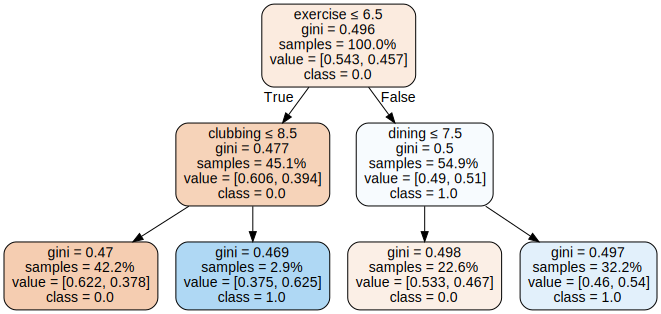

In [156]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_i, y_m_i)
import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_i.columns),  
                       
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                      
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

Classification over interest on minor race group: Black/African American and Native American

In [157]:
wave_n_i = sd[(sd['race']==1)|(sd['race']==5)].loc[:, interest]

In [158]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')

X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']

kb = fs.SelectKBest(k=5)
kb.fit(X_n_i, y_n_i)

SelectKBest(k=5, score_func=<function f_classif at 0x000001CA9C2F4400>)

In [159]:
# list out the 5 interests that Kbest chose
names = X_n_i.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

  Feat_names   F_Scores
2     hiking  36.192543
0    museums  17.223820
1        art  13.870620
4       yoga   8.376817
3    reading   8.220813


In [160]:
# best interests according to kbest
interest_best = ['dec_o','hiking','museums','art','reading','yoga']
wave_n_i = sd[(sd['race']==1)|(sd['race']==5)].loc[:, interest_best]

In [161]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')

In [162]:
# define X and y
X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']
# to see the distribution of y
len(wave_n_i[wave_n_i['dec_o']==1])
len(wave_n_i[wave_n_i['dec_o']==0])

143

218

In [163]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_i, y_n_i)

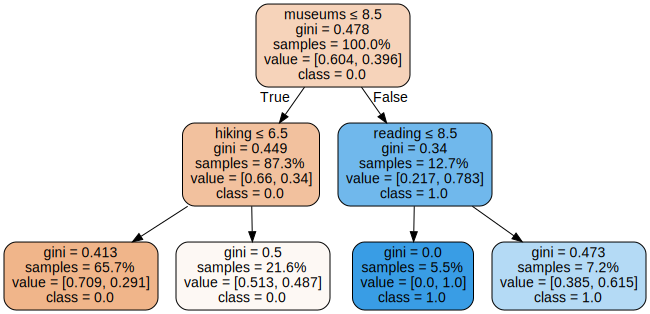

In [164]:
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_i.columns),  
                        #class_names = ['1.0' if i == 1 else '0.0' for i in y.unique()] ,
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

#### Attributes

We did the same thing over attributes to see how your partner's rating on you influence his/her decision. We also did this on two race groups to find out whether the attributes that got you partner to say yes changed among different races. 

Classification over attributes on major race group: European/Caucasian-American

In [165]:
attributes=['dec_o','gender','attr_o', 'sinc_o', 'intel_o','fun_o', 
            'amb_o', 'shar_o','prob_o','met_o']

In [166]:
wave_m_a = sd[sd['race']==2].loc[:, attributes]

In [167]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')

In [168]:
# define X and y
X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']

In [169]:
kb = fs.SelectKBest(k=4)
kb.fit(X_m_a, y_m_a)

names = X_m_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x000001CA9C2F4400>)

  Feat_names    F_Scores
0     attr_o  918.213659
1      fun_o  643.311543
2     shar_o  553.036362
3     prob_o  341.224529


In [170]:
# best attributes according to kbest
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']

In [171]:
wave_m_a = sd[sd['race']==2].loc[:, attributes_best]

In [172]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')

In [173]:
X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']
# distribution of y
len(wave_m_a[wave_m_a['dec_o']==1])
len(wave_m_a[wave_m_a['dec_o']==0])

1447

1630

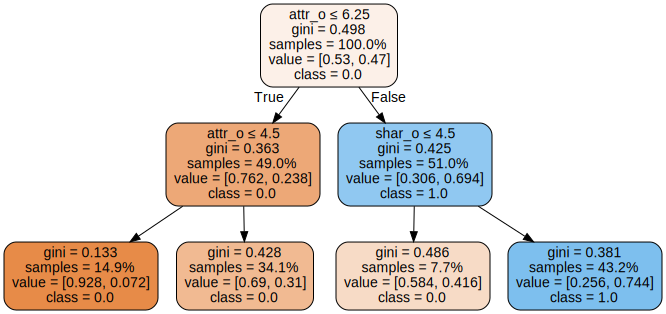

In [174]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_a, y_m_a)

dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

Classification over attributes on minor race group: Black/African American and Native American

In [175]:
wave_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes]

In [176]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')
# define X and y
X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']

In [177]:
kb = fs.SelectKBest(k=4)
kb.fit(X_n_a, y_n_a)

names = X_n_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=4, score_func=<function f_classif at 0x000001CA9C2F4400>)

  Feat_names   F_Scores
0     attr_o  61.687932
1      fun_o  50.253904
2     shar_o  44.618446
3     prob_o  29.139577


In [178]:
# best attributes according to kbest
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
wave_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes_best]

In [179]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')

In [180]:
# define X and y
X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']
# distribution of y
len(wave_n_a[wave_n_a['dec_o']==1])
len(wave_n_a[wave_n_a['dec_o']==0])

127

191

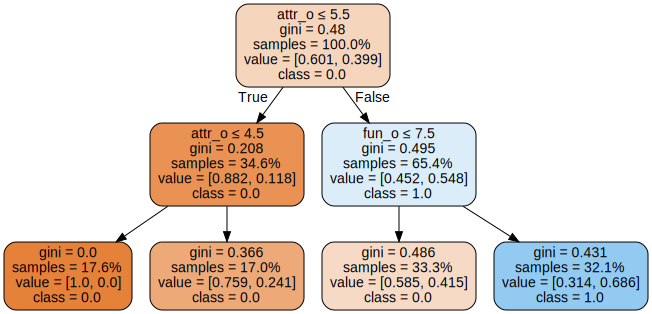

In [181]:
dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_a, y_n_a)


dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

# Reference

Clustering: https://github.com/samorani/Data-Science-Analysis-with-Python


In [182]:
Descriptive analysis : https://www.kaggle.com/piecurus/a-gender-perspective-of-participants

SyntaxError: invalid syntax (<ipython-input-182-1c52f568ae2b>, line 1)

In [ ]:
https://seaborn.pydata.org/generated/seaborn.countplot.html